# Imports

In [3]:
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import string

#! python3 -m pip install nltk
#! echo "https://ashleygingeleski.com/2021/03/31/sentiment-analysis-of-product-reviews-with-python-using-nltk/"
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk import classify
from nltk import NaiveBayesClassifier

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')


[nltk_data] Downloading package stopwords to /home/murthy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/murthy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/murthy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/murthy/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Inits , Global configs

In [7]:
data_maps = {
            "Robinhood_GooglePlay_Reviews_enUS.csv":["score","content","at"],
            "Reviews 2.csv":["Rating",'Review Text',"Date"],
            "GooglePayIndia.csv":["score","content","at"],
            "DisneylandReviews.csv":["Rating",'Review_Text',"Year_Month"],
            "tripadvisor_hotel_reviews.csv":["Rating",'Review',None],
            "PhonePayIndia.csv":["score","content","at"],
            "PaytmIndia.csv":["score","content","at"]
}
# data_maps = {
#             "PhonePayIndia.csv":["score","content","at"]
# }

# Tag Extraction

In [37]:
from nltk.tokenize import RegexpTokenizer
import nltk.tokenize as nt
import csv
from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re


In [75]:

class DataTagger():
    def __init__(self,fname):
        self.review_file = fname
        self.generate_splits()
        self.regex = re.compile('[^a-zA-Z\s0-9]')
        self.words = set(nltk.corpus.words.words())
        
    def generate_splits(self):
    #for file in files:
        file = self.review_file
        self.reviews = pd.read_csv(file)
        bname = os.path.basename(file)
        if data_maps[bname][2] is None:
            new_reviews = self.reviews[data_maps[os.path.basename(file)][:2]].to_numpy()
            
            pos_df = new_reviews[new_reviews[:,0] >= 4]
            neg_df = new_reviews[new_reviews[:,0] < 4]            
            self.df_pos = pd.DataFrame(data=pos_df,index=None,columns=["score", "review_text"])
            self.df_neg = pd.DataFrame(data=neg_df,index=None,columns=["score", "review_text"])
        else:
            new_reviews = self.reviews[data_maps[os.path.basename(file)]].to_numpy()
            pos_df = new_reviews[new_reviews[:,0] >= 4]
            neg_df = new_reviews[new_reviews[:,0] < 4]
            self.df_pos = pd.DataFrame(data=pos_df,index=None,columns=["score", "review_text","Date"]).sort_values(by=['Date'])
            self.df_neg = pd.DataFrame(data=neg_df,index=None,columns=["score", "review_text","Date"]).sort_values(by=['Date'])
        self.df_pos.to_csv(os.path.basename(file)[:-4]+"_pos.csv",index=None,)
        self.df_neg.to_csv(os.path.basename(file)[:-4]+"_neg.csv",index=None,) 
            
    def plot_sentiments(self):
        fig = plt.figure()
        fig.set_size_inches(20, 10)        
        Sentiment_count=self.reviews.groupby(data_maps[os.path.basename(file)][0]).count()
        plt.bar(Sentiment_count.index.values, Sentiment_count[data_maps[os.path.basename(file)][1]])        
        plt.xlabel('Review Sentiments')
        plt.ylabel('Number of Review')
        plt.show()
        print("score", "counts")
        print(self.reviews[data_maps[os.path.basename(file)][0]].value_counts())
    
    def preprocess(self):
        pos_list = self.df_pos.to_numpy()[:,1].tolist()
        neg_list = self.df_neg.to_numpy()[:,1].tolist()

        self.senti_dict = {"pos": pos_list,
                      "neg":neg_list}
        
        stop = set(stopwords.words('english') + list(string.punctuation))
        tokenizer = WhitespaceTokenizer()
        self.features = []
        self.filtered_list=[]
        for label,s_list in self.senti_dict.items():
            list_lowered = [str(word).lower() for word in s_list]
            list_to_string = ' '.join([str(elem) for elem in list_lowered])      
            filtered_list_tmp = [w for w in tokenizer.tokenize(list_to_string) if w not in stop] 
            filtered_list = [w.strip(string.punctuation) for w in filtered_list_tmp]
            
            self.features.append([(self.word_features(f), label) for f in filtered_list])
            self.filtered_list.append(filtered_list)

    def remove_punct(self,text):
        tokenizer = RegexpTokenizer(r"\w+")
        lst=tokenizer.tokenize(' '.join(text))
        return lst
    
    def generate_tags(self):
        lines = []
        prefixes = ["pos","neg"]
        
        fname = os.path.basename(self.review_file)
        p_fname = fname[:-4]+"_pos.csv"
        n_fname = fname[:-4]+"_neg.csv"
        
        pos_df = pd.read_csv(p_fname)
        neg_df = pd.read_csv(n_fname)
        pos_list = pos_df.to_numpy()[:,1].tolist()
        neg_list = neg_df.to_numpy()[:,1].tolist()
    
        filter_list = [pos_list,neg_list]
        #for idx,senti_list in enumerate(self.filtered_list):
        for idx,senti_list in enumerate(filter_list):
            pos_list =senti_list
            for i in tqdm(range(len(pos_list))):
                #for text in pos_list:#[:10]:
                raw_text = pos_list[i]

                if not isinstance(raw_text, str):
                    continue
                #text = "me kya ho raha hai  brother"
                #text = " ".join(w for w in nltk.wordpunct_tokenize(raw_text) if w.lower() in words or not w.isalpha())
                text = raw_text
                text.lower()
                # #First parameter is the replacement, second parameter is your input string
                text = self.regex.sub('', text)


                # SENTENCE TOKENIZATION
                ss=nt.sent_tokenize(text)
                ss =self.remove_punct(ss)

                # WORD TOKENIZATION
                tokenized_sent=[nt.word_tokenize(sent) for sent in ss]


                # REMOVE STOP WORDS
                pos_list_lowered = [str(word).lower() for word in tokenized_sent]
                pos_list_to_string = ' '.join([str(elem) for elem in pos_list_lowered])

                tokenizer = WhitespaceTokenizer()
                stop = set(stopwords.words('english') + list(string.punctuation))
                filtered_pos_list = [w for w in tokenizer.tokenize(pos_list_to_string) if w not in stop] 

                # Stemming
                ps = PorterStemmer()
                stemmed_words = [ps.stem(w) for w in filtered_pos_list]         
                #lem = WordNetLemmatizer()

                # POS tagging
                #stemmed_list_to_string = ' '.join([str(elem) for elem in stemmed_words])
                #print(stemmed_list_to_string,stemmed_words)
                #if stemmed_list_to_string is str:
                #    pos_sentences=nltk.pos_tag(stemmed_list_to_string)
                #else:
                #pos_sentences=[nltk.pos_tag(sent) for sent in stemmed_list_to_string]
                #print(stemmed_words)

                pos_sentences=[nltk.pos_tag(sent) for sent in tokenized_sent]

                nouns = []
                adj = []
                verb = []
                for r in pos_sentences:#[:10]:
                    for s   in r:
                        (val,key) = s
                        
                        #print("iterate",val,key)
                        if key == "NN" or key =="NNP" or key =="NNS":
                            nouns.append(val)
                        if key == "JJ" or key =="JJR" or key =="JJS":
                            adj.append(val)
                        if key == "VB" or key =="VBG" \
                            or key =="VBD" or key =="VBN" \
                            or key =="VBP" or key =="VBZ" :
                            verb.append(val)
                '''
                print("-"*20)
                print("Text",text)
                print("Nouns",nouns)
                print("Adj",adj)
                print("Verb",verb)
                nouns = "" if nouns == [] else nouns
                adj = "" if adj == [] else adj
                verb = "" if verb == [] else verb
                print(tokenized_sent,[nouns,adj,verb])
                '''
                lines.append([text,nouns,adj,verb])
            rev_base_name = os.path.basename(self.review_file)
            tag_file_name = rev_base_name[:-4]+"_{}_tags.csv".format(prefixes[idx])        
            tag_file_name_clean = "pos_tags/"+rev_base_name[:-4]+"_{}_tags_clean.csv".format(prefixes[idx])        
            self.write_tags(tag_file_name,lines)            
            ! cat $tag_file_name | sed "s/\"//" > tmp_out.txt
            ! cat tmp_out.txt | sed "s/\'//" > $tag_file_name_clean
            ! rm -f  tmp_out.txt $tag_file_name
    
    def generate_features(self):
        labeledwords = self.features[0]+self.features[1] #positive_features + negative_features
        random.shuffle(labeledwords)
        self.train_set, self.test_set = labeledwords[2000:], labeledwords[:500]
        return self.train_set,self.test_set
    
    def train_classifier(self):#train_set, test_set):    
        self.classifier = nltk.NaiveBayesClassifier.train(self.train_set)
        self.accuracy = nltk.classify.accuracy(self.classifier, self.test_set)
        return self.classifier,self.accuracy

    def word_features(self,words):
        return dict([(word, True) for word in words.split()])

    def write_tags(self,csv_fname,data):
        # writing to csv file 
        print(csv_fname)
        with open(csv_fname, 'a') as csvfile: 
            # creating a csv writer object 
            csvwriter = csv.writer(csvfile,delimiter=":") 
            # writing the fields 
            csvwriter.writerows(data)       
    
    def cluster_entities(self):
        # mini-batch k-means clustering
        from numpy import unique
        from numpy import where
        from sklearn.datasets import make_classification
        from sklearn.cluster import MiniBatchKMeans
        from matplotlib import pyplot
        # define dataset
        X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2, random_state=4)
        
        # vectorize TF_ID
        
        # Word embedding
        
        # generate Features 
        # self.generate_features()
        
        # define the model
        print(X.shape)
        
        model = MiniBatchKMeans(n_clusters=2)
        # fit the model
        model.fit(X)
        # assign a cluster to each example
        yhat = model.predict(X)
        # retrieve unique clusters
        clusters = unique(yhat)
        # create scatter plot for samples from each cluster
        for cluster in clusters:
            # get row indexes for samples with this cluster
            row_ix = where(yhat == cluster)
            # create scatter of these samples
            pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        # show the plot
        pyplot.show()            
        
        

=================PhonePayIndia.csv=================


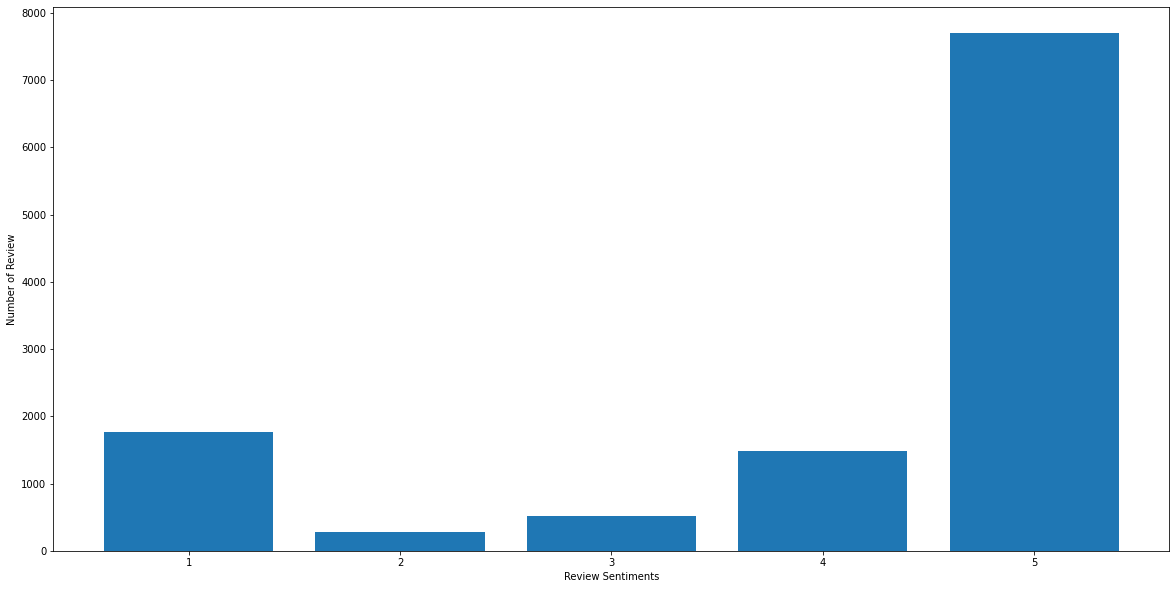

score counts
5    7699
1    1765
4    1483
3     517
2     277
Name: score, dtype: int64


100%|██████████| 9182/9182 [00:06<00:00, 1429.89it/s]

PhonePayIndia_pos_tags.csv



100%|██████████| 2559/2559 [00:05<00:00, 507.06it/s]

PhonePayIndia_neg_tags.csv


(1000, 2)


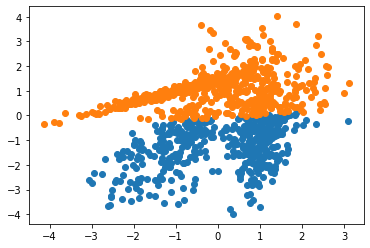


PhonePayIndia.csv  - Classifier Test Accuracy:  0.714



In [76]:

for file,_ in data_maps.items():
    
    file = "PhonePayIndia.csv" # Commment to run on all datasets
    
    print("================={}=================".format(file))
    tagger = DataTagger("raw_data/"+file)
    tagger.plot_sentiments()
    tagger.preprocess()
    tagger.generate_tags()
    tagger.generate_features()
    tagger.train_classifier()
    tagger.cluster_entities()
    print()
    print(file," - Classifier Test Accuracy: ",tagger.accuracy)
    print()
    break